In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import mglearn 
from IPython.display import display
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from sklearn.datasets import load_files
%matplotlib 
%matplotlib inline
%run jasmine.py

Using matplotlib backend: MacOSX


In [2]:
#Loading experiment title/description from data folder
dataset=load_files('data')

In [3]:
#Extracting Experiment IDs from file names data//no//exp_ID --> exp_ID
print type(dataset.filenames)

exp_IDs = []

for fn in dataset.filenames: 
    if "yes" not in fn:
        id=fn.replace('data\\no\\','')
        
    else: 
        id=fn.replace('data\\yes\\','')
       
    exp_IDs.append(id)

<type 'numpy.ndarray'>


In [19]:
#splitting 'yes'/'no' files ramdomly into training and test set
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import StratifiedShuffleSplit

file_names_train, file_names_test,docs_train, docs_test, y_train, y_test =train_test_split(exp_IDs, dataset.data, dataset.target,test_size=0.25, train_size=0.75,random_state=10)
print "Number of Experiments: %d" %(len(dataset.filenames))
print
print "Number of Training Experiments: %d" % (len(docs_train))
print "Yes count: %d" % (y_train.tolist()).count(1)
print "No count: %d" % (y_train.tolist()).count(0)
print 
print "Number of Test Experiments: %d" % (len(docs_test))
print "Yes count: %d" % (y_test.tolist()).count(1)
print "No count: %d" % (y_test.tolist()).count(0)

Number of Experiments: 2379

Number of Training Experiments: 1784
Yes count: 352
No count: 1432

Number of Test Experiments: 595
Yes count: 134
No count: 461


# TFIDF VECTORIZER w/ beta=4

In [20]:
from sklearn import metrics 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
import mglearn




clf=Pipeline([('cvect',TfidfVectorizer(strip_accents='ascii',token_pattern=u'(?u)\\b([a-z_]\w+)\\b',stop_words="english")),
              ('stdsclr',StandardScaler(copy=True,with_mean=False, with_std=True)),
              ('sgd',SGDClassifier(verbose=0,eta0=1,class_weight='balanced')),
])

parameters={ 'cvect__ngram_range':[(1,1),(1,2),(1,3)],
             'cvect__min_df':[2],
             'cvect__max_df':[.98],
             'sgd__eta0':[.001,.01,.1,1],
             'sgd__alpha':[.0001,.001,.01,.1],
             'sgd__loss':[ 'hinge', 'log'],
             'sgd__penalty':['l2','l1'],
             'sgd__n_iter':[5],
             'sgd__learning_rate':['constant','invscaling'],
            }

beta=4
f_scorer=make_f_scorer(beta)

#Running GridSearch
gs_clf=GridSearchCV(clf,parameters,scoring=f_scorer,n_jobs=-1,verbose=1)
gs_clf=gs_clf.fit(docs_train,y_train)
trainedCLF=gs_clf.best_estimator_
vectorizer=gs_clf.best_estimator_.named_steps["cvect"]

print ("SGD Classifier with Tfidf Vectorizer: \n")
for param_name in sorted(parameters.keys()):
    print("%s:%r"%(param_name,gs_clf.best_params_[param_name]))
   

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  3.7min finished


SGD Classifier with Tfidf Vectorizer: 

cvect__max_df:0.98
cvect__min_df:2
cvect__ngram_range:(1, 2)
sgd__alpha:0.1
sgd__eta0:0.001
sgd__learning_rate:'constant'
sgd__loss:'hinge'
sgd__n_iter:5
sgd__penalty:'l1'


In [21]:

y_test_predicted=trainedCLF.predict(docs_test)
y_train_predicted=trainedCLF.predict(docs_train)

results(y_test,y_test_predicted,y_train,y_train_predicted,beta)

Test Set Classification Report & Confusion Matrix: 

             precision    recall  f1-score   support

        yes       0.46      1.00      0.63       134
         no       1.00      0.66      0.80       461

avg / total       0.88      0.74      0.76       595

F 4: 0.936


[[134   0]
 [156 305]]


Training Set Classification Report & Confusion Matrix: 

             precision    recall  f1-score   support

        yes       0.41      1.00      0.58       352
         no       1.00      0.65      0.79      1432

avg / total       0.88      0.72      0.75      1784

F 4: 0.921
[[351   1]
 [498 934]]


In [22]:
%run jasmine.py
feature_names=np.array(vectorizer.get_feature_names())
print ("Number of Features: %d\n" % len(feature_names))
print  ("First ten features: {}\n".format(feature_names[0:10]))
middle_ten =len(feature_names)/2 +10 
print ("Middle ten features: {} \n".format(feature_names[len(feature_names)/2: middle_ten]))
print  ("Last ten features: {}\n".format(feature_names[-10:]))
falselyReported(y_test, y_test_predicted, file_names_test)

Number of Features: 13778

First ten features: [u'a2' u'a_x0080__x0093_' u'a_x0080__x0093_ mice' u'a_x0084_s'
 u'a_x0088__x0092_' u'a_x0088__x0092_ mice' u'a_x0088__x0092_ retina'
 u'a_x0089_1' u'a_x0089_1 fold' u'a_x0089_1 value']

Middle ten features: [u'knockout newborn' u'knockout strain' u'knockout vs' u'knockout wild'
 u'knockouts' u'knockouts time' u'knowledge' u'knowledge pathogenesis'
 u'known' u'known effects'] 

Last ten features: [u'zones' u'zones germinal' u'zooepidemicus' u'zooepidemicus colony'
 u'zooepidemicus strongly' u'zscan4' u'zt20' u'zt6' u'zt6 zt20' u'zygotic']

total count:  156

Number of False Positves:  156
['data/no/E-BAIR-12', 'data/no/E-GEOD-38001', 'data/no/E-GEOD-769', 'data/no/E-GEOD-77846', 'data/no/E-MTAB-3814', 'data/no/E-GEOD-58998', 'data/no/E-MTAB-1569', 'data/no/E-GEOD-31013', 'data/no/E-GEOD-44651', 'data/no/E-SMDB-24', 'data/no/E-GEOD-2882']

Number of False Negatives:  0
[]


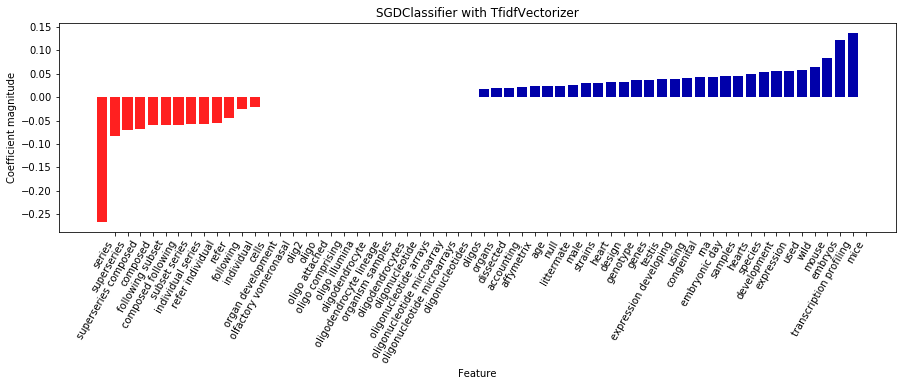

In [23]:
mglearn.tools.visualize_coefficients(
    trainedCLF.named_steps["sgd"].coef_, 
    feature_names, n_top_features=30
)
plt.title("SGDClassifier with TfidfVectorizer")

# TFIDF VECTORIZER w/ beta=2 

In [9]:
from sklearn import metrics 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
import mglearn
from sklearn.preprocessing import MaxAbsScaler
from sklearn import preprocessing

clf=Pipeline([('cvect',TfidfVectorizer(strip_accents='ascii',token_pattern=u'(?u)\\b([a-z_]\w+)\\b',stop_words="english")),
              ('stdsclr',StandardScaler(copy=True,with_mean=False, with_std=True)),
              ('sgd',SGDClassifier(verbose=0,eta0=1,class_weight='balanced')),
])

parameters={ 'cvect__ngram_range':[(1,1),(1,2),(1,3)],
             'cvect__min_df':[2],
             'cvect__max_df':[.98],
             'sgd__eta0':[.001,.01,.1,1],
             'sgd__alpha':[.0001,.001,.01,.1],
             'sgd__loss':[ 'hinge', 'log'],
             'sgd__penalty':['l2','l1'],
             'sgd__n_iter':[5],
             #'sgd__shuffle':[True,False],
             'sgd__learning_rate':['constant','invscaling'],  
        }

beta=2
f_scorer=make_f_scorer(beta)

#Running GridSearch
gs_clf=GridSearchCV(clf,parameters,scoring=f_scorer,n_jobs=-1,verbose=1)
gs_clf=gs_clf.fit(docs_train,y_train)
trainedCLF=gs_clf.best_estimator_
vectorizer=gs_clf.best_estimator_.named_steps["cvect"]

print ("SGD Classifier with Tfidf Vectorizer: \n")
for param_name in sorted(parameters.keys()):
    print("%s:%r"%(param_name,gs_clf.best_params_[param_name]))

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed:  4.1min finished


SGD Classifier with Tfidf Vectorizer: 

cvect__max_df:0.98
cvect__min_df:2
cvect__ngram_range:(1, 3)
sgd__alpha:0.01
sgd__eta0:0.001
sgd__learning_rate:'invscaling'
sgd__loss:'log'
sgd__n_iter:5
sgd__penalty:'l2'


In [10]:

y_test_predicted=trainedCLF.predict(docs_test)
y_train_predicted=trainedCLF.predict(docs_train)

print results(y_test,y_test_predicted,y_train,y_train_predicted,beta)

Test Set Classification Report & Confusion Matrix: 

             precision    recall  f1-score   support

        yes       0.62      0.93      0.74       134
         no       0.98      0.83      0.90       461

avg / total       0.90      0.85      0.86       595

F 2: 0.846


[[125   9]
 [ 78 383]]


Training Set Classification Report & Confusion Matrix: 

             precision    recall  f1-score   support

        yes       0.89      1.00      0.94       352
         no       1.00      0.97      0.98      1432

avg / total       0.98      0.97      0.98      1784

F 2: 0.975
[[ 352    0]
 [  45 1387]]
None


In [11]:
feature_names=np.array(vectorizer.get_feature_names())
print ("Number of Features: %d\n" % len(feature_names))
print  ("First ten features: {}\n".format(feature_names[0:10]))
middle_ten =len(feature_names)/2 +10 
print ("Middle ten features: {} \n".format(feature_names[len(feature_names)/2: middle_ten]))
print  ("Last ten features: {}\n".format(feature_names[-10:]))

print falselyReported(y_test, y_test_predicted, file_names_test)

Number of Features: 18859

First ten features: [u'a2' u'a_x0080__x0093_' u'a_x0080__x0093_ mice' u'a_x0084_s'
 u'a_x0088__x0092_' u'a_x0088__x0092_ mice' u'a_x0088__x0092_ mice bwa'
 u'a_x0088__x0092_ retina' u'a_x0088__x0092_ retina fold' u'a_x0089_1']

Middle ten features: [u'ko cell' u'ko cells' u'ko control' u'ko embryos' u'ko es' u'ko es cells'
 u'ko il6' u'ko il6 ko' u'ko ko' u'ko mdr2'] 

Last ten features: [u'zooepidemicus' u'zooepidemicus colony' u'zooepidemicus colony forming'
 u'zooepidemicus strongly' u'zooepidemicus strongly suggest' u'zscan4'
 u'zt20' u'zt6' u'zt6 zt20' u'zygotic']

total count:  87

Number of False Positves:  78
['data/no/E-GEOD-38001', 'data/no/E-GEOD-769', 'data/no/E-GEOD-58998', 'data/no/E-MTAB-1569', 'data/no/E-GEOD-31013', 'data/no/E-GEOD-44651', 'data/no/E-SMDB-24', 'data/no/E-GEOD-2882', 'data/no/E-GEOD-9033', 'data/no/E-GEOD-47395', 'data/no/E-GEOD-11897']

Number of False Negatives:  9
['data/yes/E-GEOD-33979', 'data/yes/E-ERAD-283', 'data/yes/E

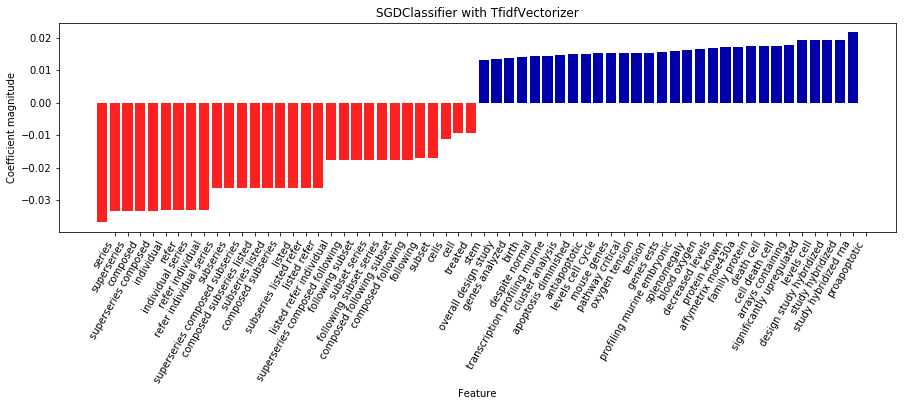

In [12]:
mglearn.tools.visualize_coefficients(
    trainedCLF.named_steps["sgd"].coef_, 
    feature_names, n_top_features=30
)
plt.title("SGDClassifier with TfidfVectorizer")

# TFIDF VECTORIZER W/ MaxAbsScaler 

In [14]:
#SGD Classifier with Tfidf Vectorizer 
from sklearn import metrics 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
import mglearn
from sklearn.preprocessing import MaxAbsScaler
from sklearn import preprocessing

clf=Pipeline([('vect',TfidfVectorizer(strip_accents='ascii',token_pattern=u'(?u)\\b([a-z_]\w+)\\b',stop_words="english")),
              ('mas',MaxAbsScaler()),
             ('sgd',SGDClassifier(eta0=1,verbose=0,class_weight='balanced')),
])

parameters={ 'vect__ngram_range':[(1,1),(1,2),(1,3)],
             'vect__min_df':[2],
             'vect__max_df':[.98],
             'sgd__alpha':[.0001,.001,.01,.1,1],
             'sgd__eta0':[.001,.01,.1,1],
             
             'sgd__loss':[ 'hinge', 'log'],
             'sgd__penalty':['l2','l1'],
             'sgd__n_iter':[5],
             'sgd__learning_rate':['constant','invscaling'],             
        }

beta=4
f_scorer=make_f_scorer(beta)

#Running GridSearch
gs_clf=GridSearchCV(clf,parameters,verbose=1, scoring=f_scorer,n_jobs=-1)
gs_clf=gs_clf.fit(docs_train,y_train)
trainedCLF=gs_clf.best_estimator_
vectorizer=gs_clf.best_estimator_.named_steps["vect"]

print ("SGD Classifier with Tfidf Vectorizer: \n")
for param_name in sorted(parameters.keys()):
    print("%s:%r"%(param_name,gs_clf.best_params_[param_name]))

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.6min
/Users/jak/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jak/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jak/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jak/anaconda/lib/python2.7/site-packages/sklearn/

SGD Classifier with Tfidf Vectorizer: 

sgd__alpha:0.001
sgd__eta0:0.1
sgd__learning_rate:'invscaling'
sgd__loss:'hinge'
sgd__n_iter:5
sgd__penalty:'l2'
vect__max_df:0.98
vect__min_df:2
vect__ngram_range:(1, 1)


In [15]:

y_test_predicted=trainedCLF.predict(docs_test)
y_train_predicted=trainedCLF.predict(docs_train)

print results(y_test,y_test_predicted,y_train,y_train_predicted,beta)

Test Set Classification Report & Confusion Matrix: 

             precision    recall  f1-score   support

        yes       0.50      0.99      0.67       134
         no       1.00      0.71      0.83       461

avg / total       0.89      0.78      0.79       595

F 4: 0.939


[[133   1]
 [132 329]]


Training Set Classification Report & Confusion Matrix: 

             precision    recall  f1-score   support

        yes       0.48      0.99      0.65       352
         no       1.00      0.74      0.85      1432

avg / total       0.90      0.79      0.81      1784

F 4: 0.935
[[ 350    2]
 [ 379 1053]]
None


In [17]:
feature_names=np.array(vectorizer.get_feature_names())
print ("Number of Features:%d\n" % len(feature_names))
print  ("First ten features: {}\n".format(feature_names[0:10]))
middle_ten =len(feature_names)/2 +10 
print ("Middle ten features: {} \n".format(feature_names[len(feature_names)/2: middle_ten]))
print  ("First ten features: {}\n".format(feature_names[-10:]))

print falselyReported(y_test, y_test_predicted, file_names_test)

Number of Features:5322

First ten features: [u'a2' u'a_x0080__x0093_' u'a_x0084_s' u'a_x0088__x0092_' u'a_x0089_1'
 u'aa' u'aa4' u'abdominal' u'aberrant' u'aberrations']

Middle ten features: [u'ldb1' u'ldlr' u'ldp' u'lead' u'leading' u'leads' u'lean' u'learning'
 u'lectin' u'led'] 

First ten features: [u'yy1' u'zebrafish' u'zinc' u'zone' u'zones' u'zooepidemicus' u'zscan4'
 u'zt20' u'zt6' u'zygotic']

total count:  133

Number of False Positves:  132
['data/no/E-GEOD-38001', 'data/no/E-GEOD-769', 'data/no/E-GEOD-77846', 'data/no/E-MTAB-3814', 'data/no/E-GEOD-58998', 'data/no/E-MTAB-1569', 'data/no/E-GEOD-31013', 'data/no/E-GEOD-44651', 'data/no/E-SMDB-24', 'data/no/E-GEOD-2882', 'data/no/E-GEOD-52416']

Number of False Negatives:  1
['data/yes/E-ERAD-283']
None


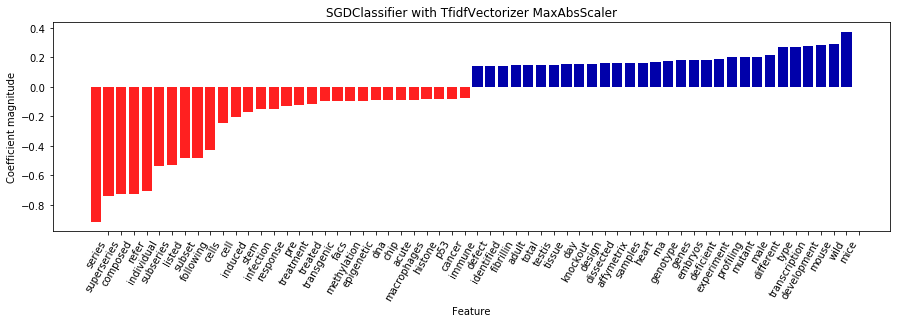

In [18]:
mglearn.tools.visualize_coefficients(
    trainedCLF.named_steps["sgd"].coef_, 
    feature_names, n_top_features=30
)
plt.title("SGDClassifier with TfidfVectorizer MaxAbsScaler")